# Volume 3 Final Notebook

In [483]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tqdm import tqdm

from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
from sklearn.model_selection import GridSearchCV, train_test_split

DATA_DIR = './FinalData/'

In [484]:
class WeatherModel():
    def __init__(self, data, model_type='ARIMA'):
        self.data = data
        self.seasonal = None
        self.residuals = None

        self.year_data = self.get_year_data()
        self.arma_models = []

        self.model_type = model_type

    def get_year_data(self):
        data = self.data.to_numpy()

        drop_rows = data.shape[0] % 365
        data = data[:-drop_rows]

        data = data.reshape(-1, 365, data.shape[1])

        return data

    def get_seasonal_trend(self):
        
        seasonal = np.mean(self.year_data, axis=0)
        self.seasonal = seasonal

        return seasonal
    
    def get_residuals(self):
        
        if self.seasonal is None:
            self.get_seasonal_trend()

        residuals = self.year_data - self.seasonal
        residuals = residuals.reshape(-1, residuals.shape[2])
        self.residuals = residuals

        return residuals
    
    def fit_arma(self, order, seasonal_order=None):


        if self.residuals is None:
            self.get_residuals()

        arma_models = []

        pbar = tqdm(total=self.residuals.shape[1])

        for i in range(self.residuals.shape[1]):
            pbar.set_description(f"Fitting {i+1}/{self.residuals.shape[1]} {self.model_type} models")
            pbar.update(1)

            if self.model_type == 'ARIMA':
                model = ARIMA(self.residuals[:, i], order=order)
            elif self.model_type == 'SARIMAX':
                if seasonal_order is None:
                    seasonal_order = (1, 0, 1, 365)
                model = SARIMAX(self.residuals[:, i], order=order, seasonal_order=seasonal_order)
            else:
                raise ValueError(f"Invalid model type. Choose 'ARIMA' or 'SARIMAX'. Got {self.model_type}.")
            model_fit = model.fit()
            arma_models.append(model_fit)
            
        self.arma_models = arma_models

        return None

    def fit(self, order):
        self.fit_arma(order)
        return None
    
    
    def predict(self, start=0, future=0):
        if len(self.arma_models) == 0:
            raise ValueError("Model not fitted yet")

        arma_predictions = np.array([model.predict(start=start, end=len(self.residuals) - start + future) for model in self.arma_models])
                
        num_stacks = arma_predictions.shape[1] // self.seasonal.shape[0]
        num_extras = arma_predictions.shape[1] % self.seasonal.shape[0]

        seasonal_predictions = np.vstack([self.seasonal for _ in range(num_stacks)])

        if num_extras > 0:
            seasonal_predictions = np.vstack((seasonal_predictions, self.seasonal[:num_extras].reshape(num_extras, -1)))



        return seasonal_predictions.T + arma_predictions

In [485]:
class NonlinearLeastSquaresModel():
    def __init__(self, model_type='linear'):
        self.theta = None
        self.shift = None
        self.scale = None
        self.bias = None
        self.model_type = model_type
        if model_type == 'linear':
            self.func = lambda x, args : args[0] * x
        elif model_type == 'gaussian':
            self.vars = None
            self.func = lambda x, args : args[0] * np.exp(-((x/args[1])**2))

    def fit(self, X, y):

        xs = np.arange(X.shape[1])
        
        shift0 = np.zeros(X.shape[0])
        scale0 = np.ones(X.shape[0])
        bias0 = 0
        if self.model_type == 'linear':
            theta0 = np.concatenate([shift0, scale0, [bias0]])
        elif self.model_type == 'gaussian':
            var0 = np.ones(X.shape[0])
            theta0 = np.concatenate([shift0, scale0, var0, [bias0]])

        def f(theta):

            if self.model_type == 'linear':
                shift = theta[:X.shape[0]]
                scale = theta[X.shape[0]:-1]
                bias = theta[-1]
            elif self.model_type == 'gaussian':
                shift = theta[:X.shape[0]]
                scale = theta[X.shape[0]:2*X.shape[0]]
                var = theta[2*X.shape[0]:-1]
                bias = theta[-1]
            

            predictions = np.zeros(X.shape[1]) 
            for i in range(X.shape[0]):
                g = CubicSpline(xs, X[i])
                if self.model_type == 'linear':
                    predictions += self.func(g(xs-shift[i]), [scale[i]])
                elif self.model_type == 'gaussian':
                    predictions += self.func(g(xs-shift[i]), [scale[i], var[i]])
            predictions += bias

            return np.mean((predictions - y)**2)
        
        res = minimize(f, theta0, method='L-BFGS-B', options={'disp': True})

        self.theta = res.x
        self.shift = self.theta[:X.shape[0]]
        self.scale = self.theta[X.shape[0]:-1]
        self.bias = self.theta[-1]
        return res

    def predict(self, X):
        predictions = np.zeros(X.shape[1])
        xs = np.arange(X.shape[1])
        for i in range(X.shape[0]):
            g = CubicSpline(xs, X[i])
            if self.model_type == 'linear':
                predictions += self.func(g(xs - self.shift[i]), [self.scale[i]])
            elif self.model_type == 'gaussian':
                predictions += self.func(g(xs - self.shift[i]), [self.scale[i], self.vars[i]])

        predictions += self.bias
        return predictions

In [486]:
def clean_weather_data(filename, start_year=2003, end_year=2024):
    data = pd.read_csv(filename)
    data = data.replace(999.9, pd.NA)
    data = data.replace(9999.9, pd.NA)
    data['PRCP'] = data['PRCP'].replace(99.99, pd.NA)
    data['DATE'] = pd.to_datetime(data['DATE'])
    data = data[(data['DATE'].dt.year >= start_year) & (data['DATE'].dt.year <= end_year)]
    data = data[~((data['DATE'].dt.month == 2) & (data['DATE'].dt.day == 29))]
    data = data.set_index('DATE')
    data = data.ffill()
    data = data[["MAX", "MIN", "TEMP", "PRCP", "DEWP", "MXSPD"]]
    return data

In [487]:
ph_data = clean_weather_data(DATA_DIR + 'ph_weather.csv', start_year=2004, end_year=2024)

In [488]:
train_int = int((len(ph_data) * .8) // 365 * 365)
test_int = len(ph_data) - train_int

In [489]:

ph_data = clean_weather_data(DATA_DIR + 'ph_weather.csv', start_year=2004, end_year=2024)

#ph_train, ph_test = train_test_split(ph_data, train_size = int(.8 * len(ph_data) // 365) * 365, shuffle=False)
ph_train, ph_test = ph_data[:train_int+1], ph_data[train_int+1:]#train_test_split(ph_data, train_size = .8, shuffle=False)

wm_ph = WeatherModel(ph_train)
wm_ph.fit(order=(1, 0, 1))
predictions = wm_ph.predict(start=0, future=test_int-1)

Fitting 1/6 ARIMA models:   0%|          | 0/6 [00:00<?, ?it/s]

Fitting 6/6 ARIMA models: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


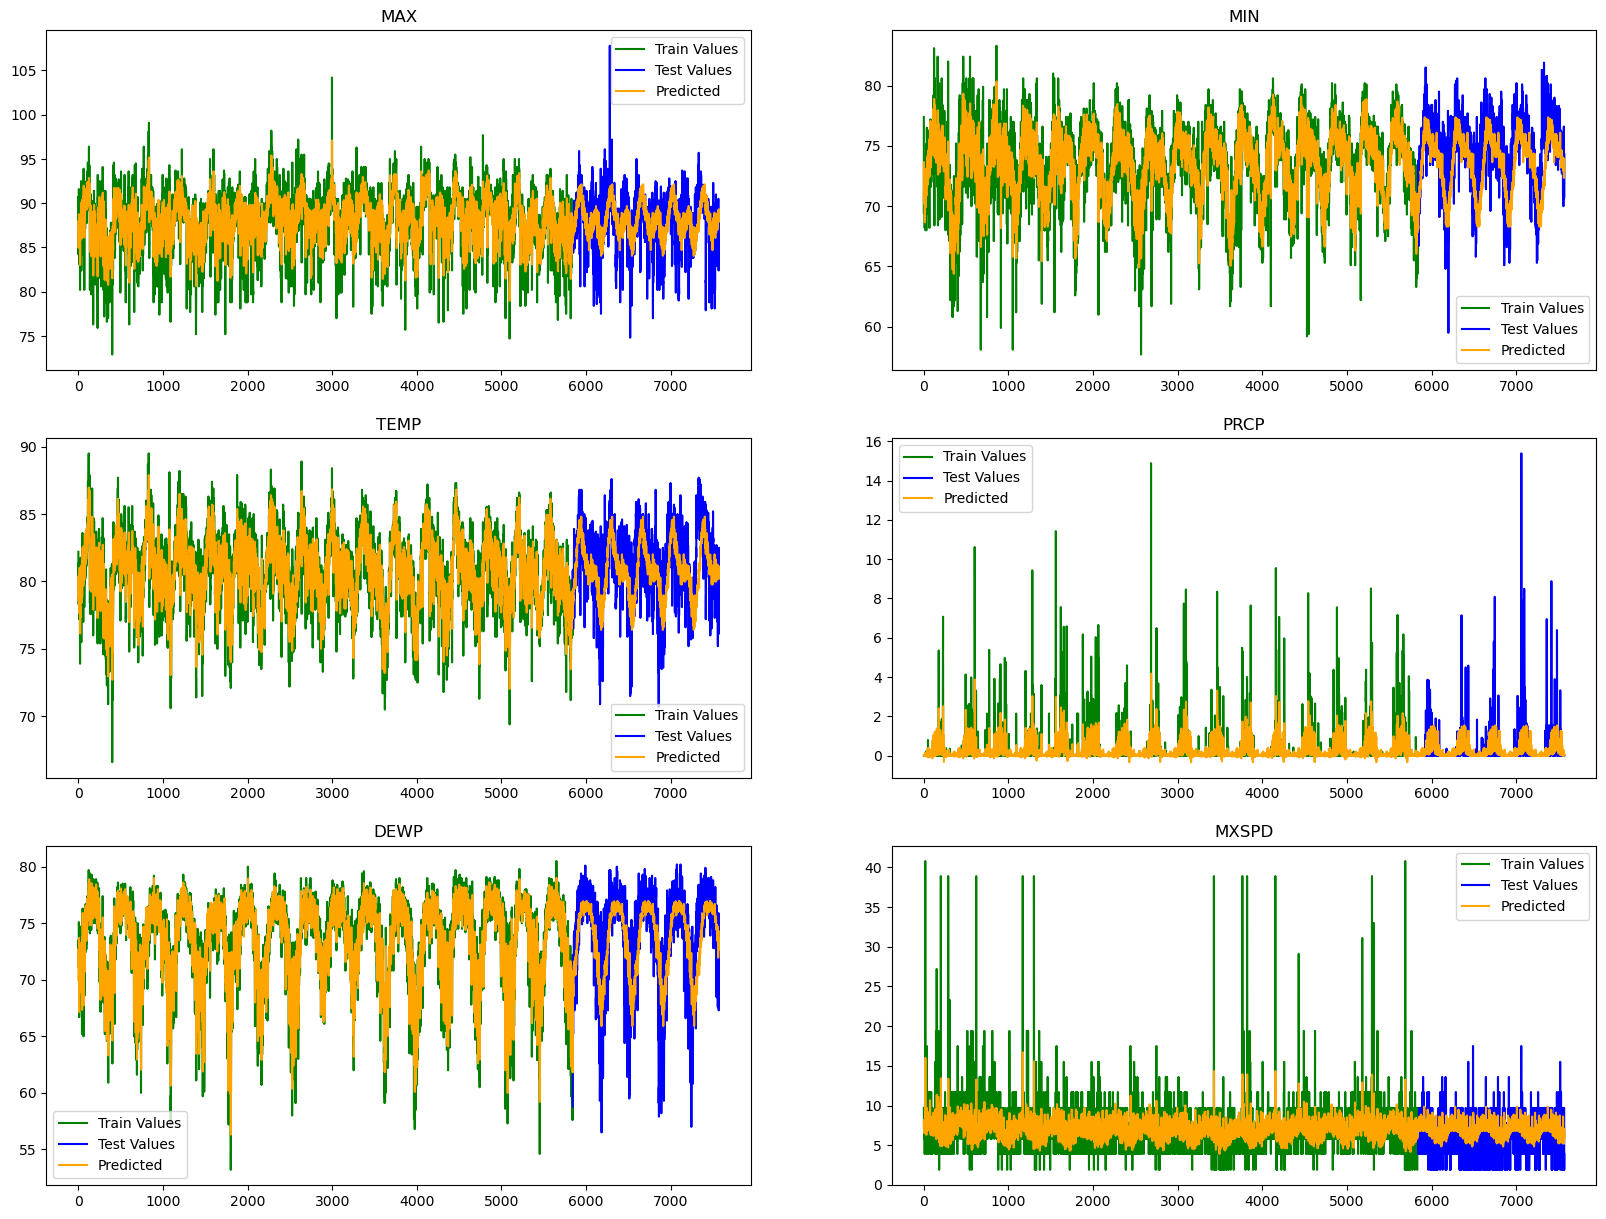

In [490]:


unrolled_data = wm_ph.year_data.reshape(-1, wm_ph.year_data.shape[2]).T
feature_names = ["MAX", "MIN", "TEMP", "PRCP", "DEWP", "MXSPD"]

plt.subplots(3, 2, figsize=(20, 15))
#print(ph_train.shape)
for i in range(len(predictions)):
    train_values = ph_train.values[:, i]
    test_values = ph_test.values[:, i]
    #print(i)
    plt.subplot(3, 2, i + 1)
    plt.title(feature_names[i])
    
    plt.plot(np.arange(len(train_values)), train_values, 'g', label='Train Values')
    plt.plot(np.arange(len(test_values)) + len(train_values), test_values, 'b', label="Test Values")
    plt.plot(predictions[i], c='orange', label='Predicted')
    plt.legend()

# for i in range(len(predictions)):
#     plt.figure(figsize=(20, 5))
#     plt.title(feature_names[i])
#     plt.plot(unrolled_data[i])
#     plt.plot(predictions[i])
#     plt.show()

/tmp/ipykernel_64575/2468680158.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weather = weather.resample('M').mean()


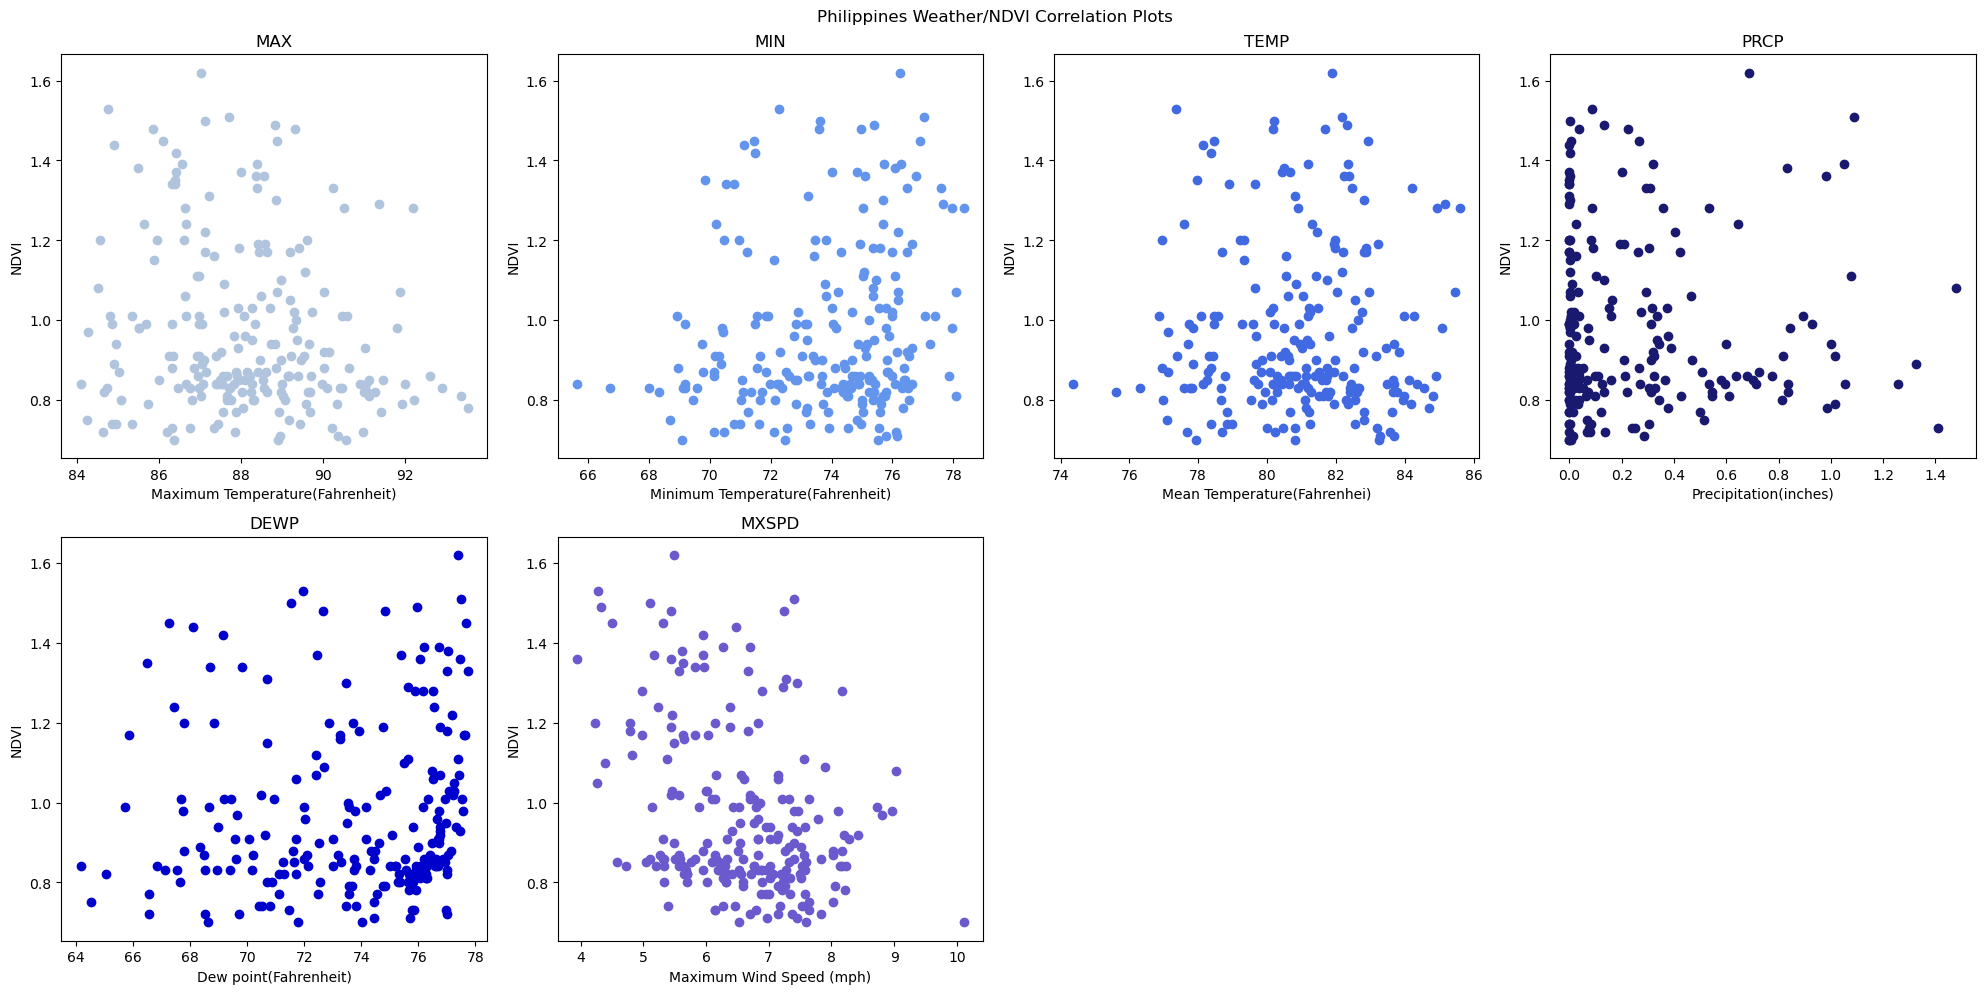

In [491]:


weather = pd.read_csv(DATA_DIR + 'ph_weather.csv')
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather = weather.set_index("DATE")
weather = weather.loc["2007":]
weather = weather.resample('M').mean()

food = pd.read_csv(DATA_DIR + 'ph_food.csv')
food = food[food["Market"] == "Ilocos Sur"]
food = food[food["Product"] == "food_price_index"]
food = food[["Date", "Close"]]
food['Date'] = pd.to_datetime(food['Date'])
food = food.set_index("Date")
food = food.loc[:"2025-01-01"]

y = food["Close"].values


c_arr = ["lightsteelblue", "cornflowerblue", "royalblue", "midnightblue", "mediumblue", "slateblue"]
full_feature_names = [
    "Maximum Temperature(Fahrenheit)", 
    "Minimum Temperature(Fahrenheit)", 
    "Mean Temperature(Fahrenhei)", 
    "Precipitation(inches)",
    "Dew point(Fahrenheit)",
    "Maximum Wind Speed (mph)"]


plt.figure(figsize=(20, 10.1))
for i in range(len(predictions)):
    plt.subplot(2,4,i+1)
    plt.title(feature_names[i])
    plt.scatter(weather[feature_names[i]], y, c=c_arr[i])
    plt.ylabel("Food")
    plt.xlabel(full_feature_names[i])
    plt.ylabel("NDVI")
    plt.suptitle("Philippines Weather/NDVI Correlation Plots")

plt.tight_layout()
plt.show()


In [492]:
chad_data = clean_weather_data(DATA_DIR + 'chad_weather.csv', start_year=2004, end_year=2024)


/tmp/ipykernel_64575/534044750.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.ffill()


In [493]:
train_int = int((len(chad_data) * .8) // 365 * 365)
test_int = len(chad_data) - train_int

#ph_train, ph_test = train_test_split(ph_data, train_size = int(.8 * len(ph_data) // 365) * 365, shuffle=False)
chad_train, chad_test = chad_data[:train_int+1], chad_data[train_int+1:]#train_test_split(ph_data, train_size = .8, shuffle=False)
print(chad_train.shape)
print(chad_train.head())
wm_chad = WeatherModel(chad_train)
wm_chad.fit(order=(1, 0, 1))
predictions = wm_chad.predict(start=0, future=test_int-1)

(5841, 6)
             MAX   MIN  TEMP  PRCP  DEWP  MXSPD
DATE                                           
2004-01-01  91.4  60.3  75.6   0.0  27.0   12.0
2004-01-02  88.9  56.3  79.5   0.0  28.7   14.0
2004-01-03  90.3  59.0  78.0   0.0  27.4   11.1
2004-01-04  92.5  59.4  82.1   0.0  30.1    7.0
2004-01-05  91.4  62.6  81.3   0.0  27.4    6.0


Fitting 4/6 ARIMA models:  67%|██████▋   | 4/6 [00:02<00:01,  1.47it/s]/home/jcdutoit/miniconda3/envs/acme/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jcdutoit/miniconda3/envs/acme/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
Fitting 6/6 ARIMA models: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


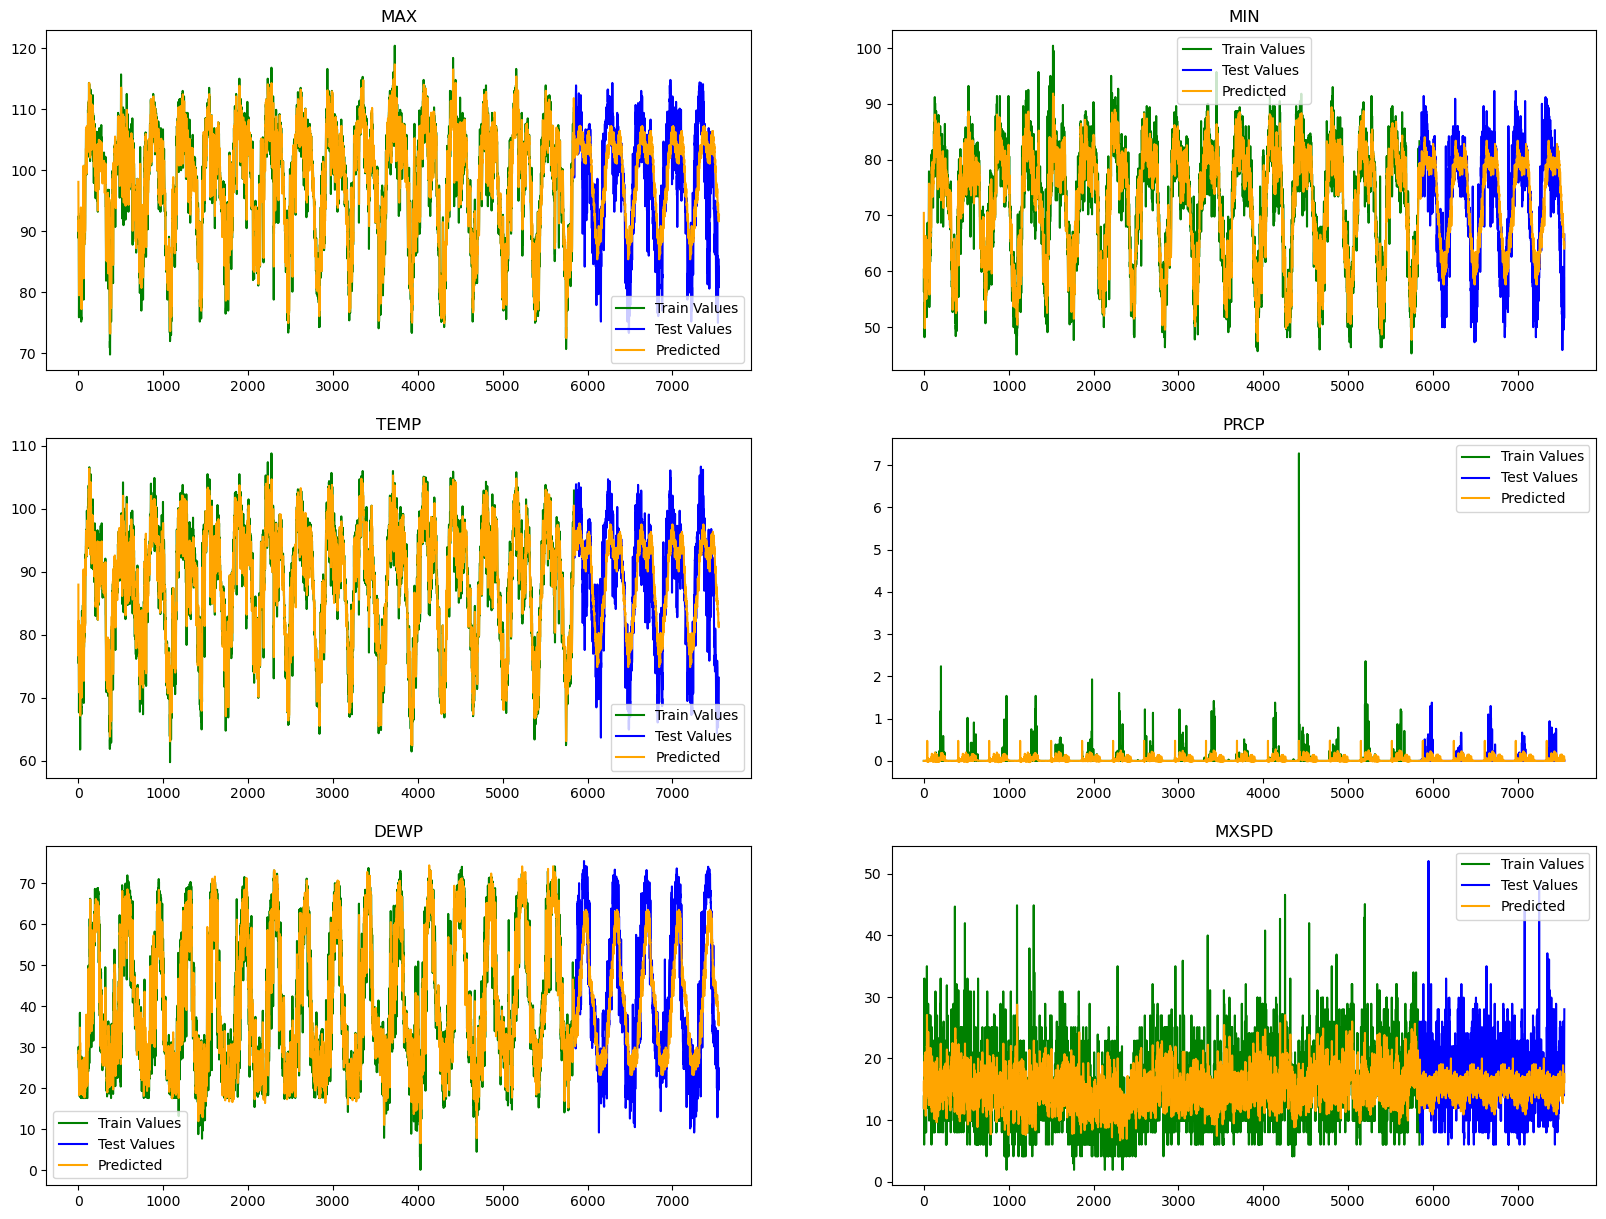

In [494]:
unrolled_data = wm_chad.year_data.reshape(-1, wm_chad.year_data.shape[2]).T

plt.subplots(3, 2, figsize=(20, 15))
#print(ph_train.shape)
for i in range(len(predictions)):
    train_values = chad_train.values[:, i]
    test_values = chad_test.values[:, i]
    #print(i)
    plt.subplot(3, 2, i + 1)
    plt.title(feature_names[i])
    
    plt.plot(np.arange(len(train_values)), train_values, 'g', label='Train Values')
    plt.plot(np.arange(len(test_values)) + len(train_values), test_values, 'b', label="Test Values")
    plt.plot(predictions[i], c='orange', label='Predicted')
    plt.legend()

/tmp/ipykernel_64575/534044750.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.ffill()


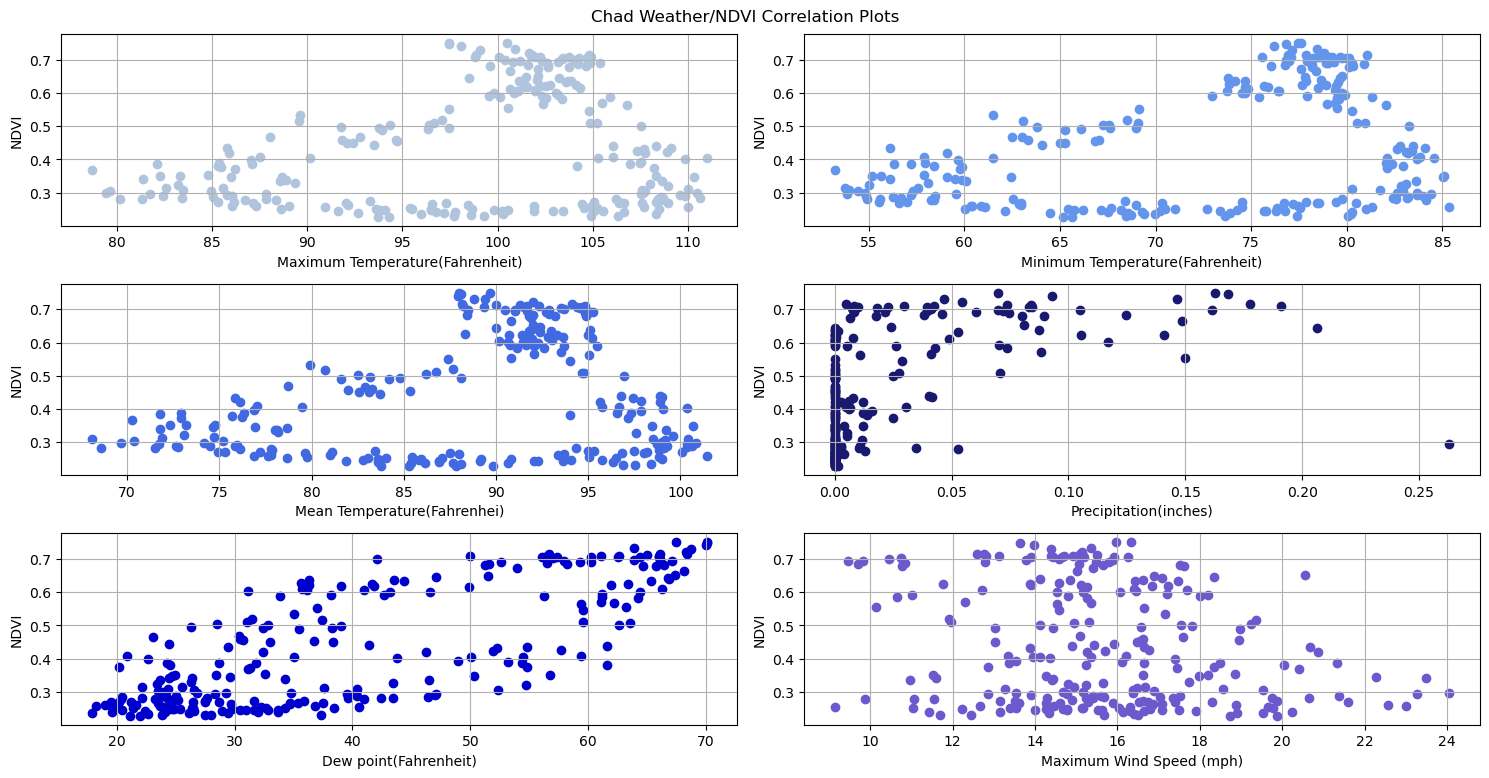

In [495]:
weather = clean_weather_data(DATA_DIR + 'chad_weather.csv', start_year=2003, end_year=2022)
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather = weather.resample('ME').mean()

green = pd.read_csv(DATA_DIR + 'chad_green.csv')
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year <= 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('ME').mean()

c_arr = ["lightsteelblue", "cornflowerblue", "royalblue", "midnightblue", "mediumblue", "slateblue"]
full_feature_names = [
    "Maximum Temperature(Fahrenheit)", 
    "Minimum Temperature(Fahrenheit)", 
    "Mean Temperature(Fahrenhei)", 
    "Precipitation(inches)",
    "Dew point(Fahrenheit)",
    "Maximum Wind Speed (mph)"]

chad_y = green.values
chad_weather = weather.values.T

plt.figure(figsize=(15, 10))
for i in range(len(chad_weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(chad_weather[i], chad_y, c=c_arr[i])
    plt.xlabel(full_feature_names[i])
    plt.ylabel("NDVI")
    plt.suptitle("Chad Weather/NDVI Correlation Plots")
    plt.grid()

plt.tight_layout()
plt.show()


In [496]:
uk_data = clean_weather_data(DATA_DIR + 'uk_weather.csv', start_year=2004, end_year=2024)
train_int = int((len(chad_data) * .8) // 365 * 365)
test_int = len(chad_data) - train_int

#ph_train, ph_test = train_test_split(ph_data, train_size = int(.8 * len(ph_data) // 365) * 365, shuffle=False)
uk_train, uk_test = uk_data[:train_int+1], uk_data[train_int+1:]#train_test_split(ph_data, train_size = .8, shuffle=False)
print(uk_train.shape)
wm_uk = WeatherModel(uk_train)
wm_uk.fit(order=(1, 0, 1))
predictions = wm_uk.predict(start=0, future=test_int-1)

/tmp/ipykernel_64575/534044750.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.ffill()


(5841, 6)


Fitting 4/6 ARIMA models:  67%|██████▋   | 4/6 [00:01<00:01,  1.99it/s]/home/jcdutoit/miniconda3/envs/acme/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Fitting 6/6 ARIMA models: 100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


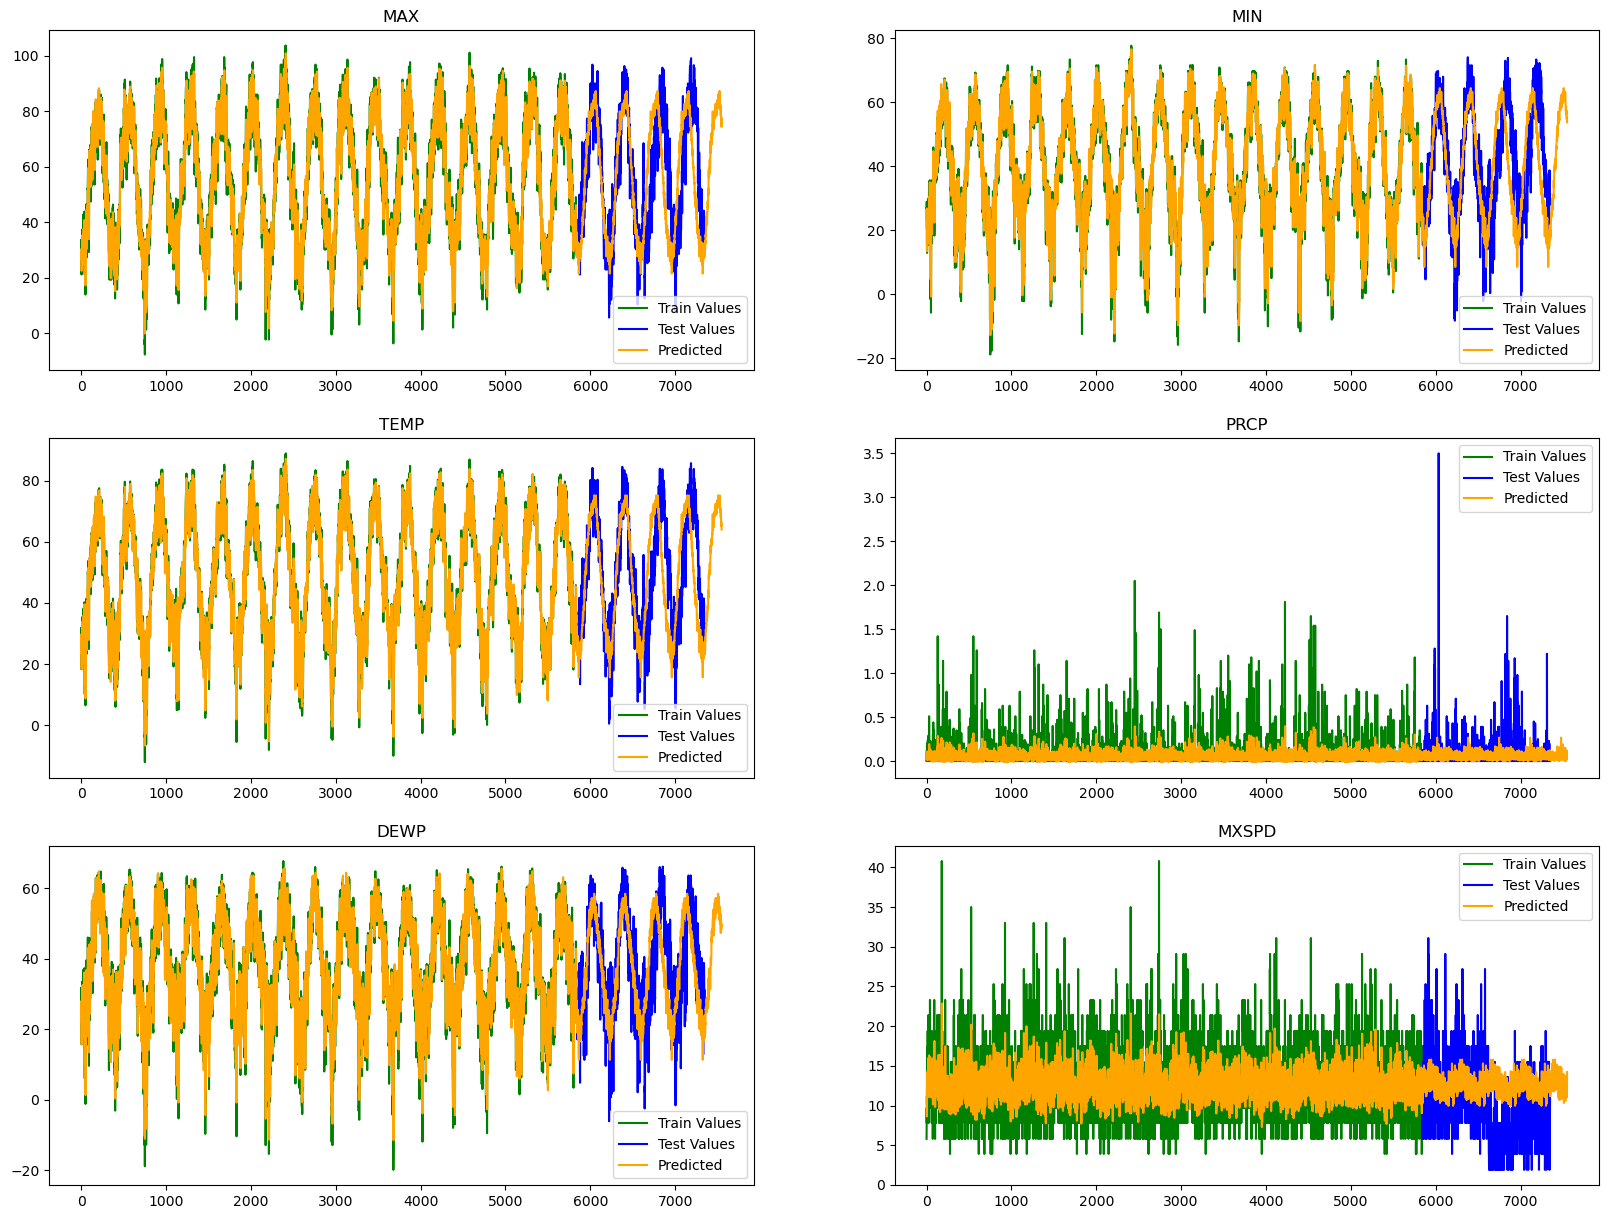

In [497]:
unrolled_data = wm_uk.year_data.reshape(-1, wm_uk.year_data.shape[2]).T

plt.subplots(3, 2, figsize=(20, 15))
#print(ph_train.shape)
for i in range(len(predictions)):
    train_values = uk_train.values[:, i]
    test_values = uk_test.values[:, i]
    #print(i)
    plt.subplot(3, 2, i + 1)
    plt.title(feature_names[i])
    
    plt.plot(np.arange(len(train_values)), train_values, 'g', label='Train Values')
    plt.plot(np.arange(len(test_values)) + len(train_values), test_values, 'b', label="Test Values")
    plt.plot(predictions[i], c='orange', label='Predicted')
    plt.legend()

/tmp/ipykernel_64575/534044750.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.ffill()


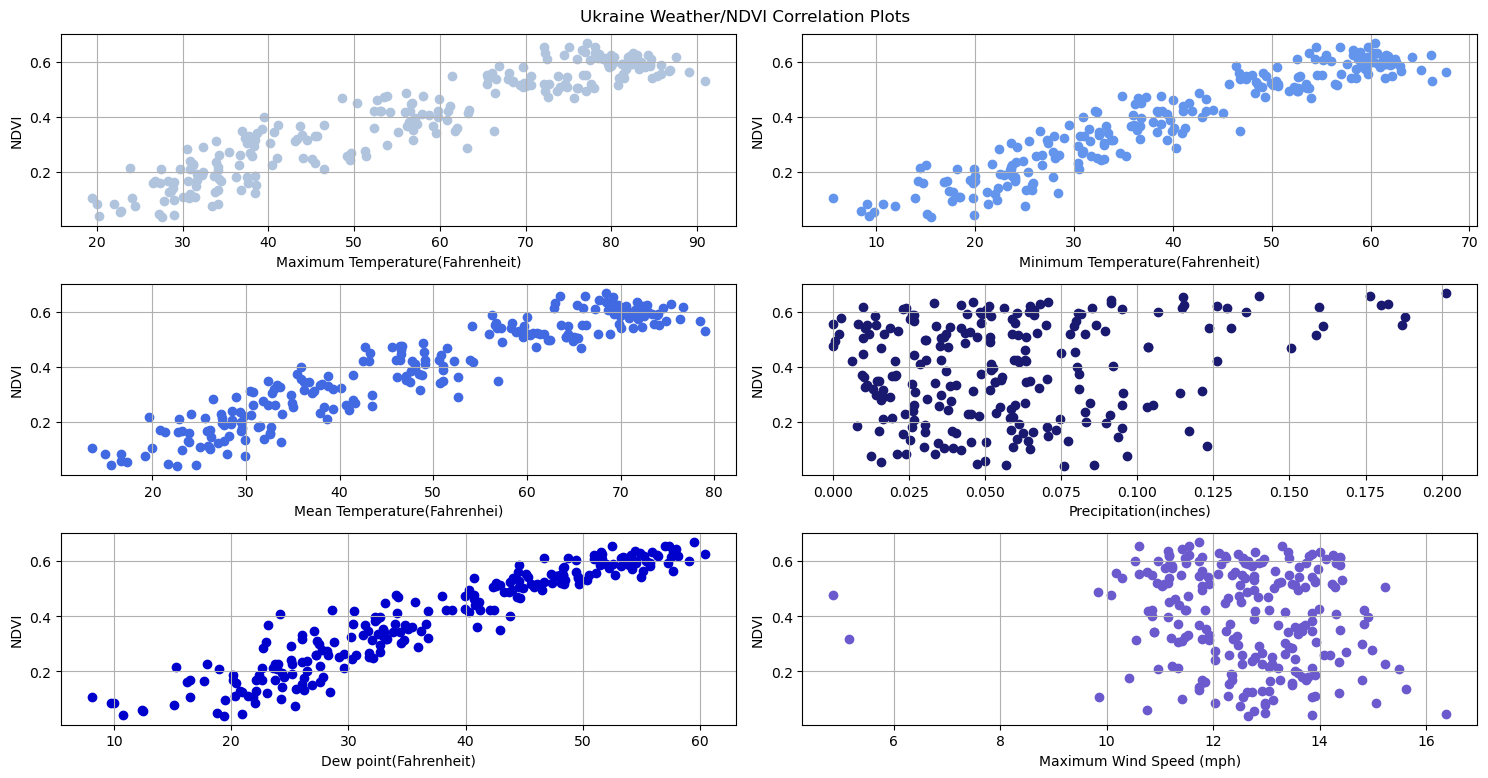

In [498]:
weather = clean_weather_data(DATA_DIR + 'uk_weather.csv', start_year=2003, end_year=2022)
# weather = pd.DataFrame(wm.residuals, columns=feature_names)
weather = weather.resample('ME').mean()

green = pd.read_csv(DATA_DIR + 'uk_green.csv')
green["#date"] = pd.to_datetime(green["#date"])
green = green[(green["#date"].dt.year >= 2003) & (green["#date"].dt.year <= 2022)]
green = green.set_index("#date")
green["residuals"] = green["#indicator+vim+num"] #- green["#indicator+vim_avg+num"]
green = green["residuals"].resample('ME').mean()

c_arr = ["lightsteelblue", "cornflowerblue", "royalblue", "midnightblue", "mediumblue", "slateblue"]
full_feature_names = [
    "Maximum Temperature(Fahrenheit)", 
    "Minimum Temperature(Fahrenheit)", 
    "Mean Temperature(Fahrenhei)", 
    "Precipitation(inches)",
    "Dew point(Fahrenheit)",
    "Maximum Wind Speed (mph)"]

uk_y = green.values
uk_weather = weather.values.T

plt.figure(figsize=(15, 10))
for i in range(len(uk_weather)):
    plt.subplot(4, 2, i+1)
    plt.scatter(uk_weather[i], uk_y, c=c_arr[i])
    plt.xlabel(full_feature_names[i])
    plt.ylabel("NDVI")
    plt.suptitle("Ukraine Weather/NDVI Correlation Plots")
    plt.grid()

plt.tight_layout()
plt.show()

(6, 184)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.94611D+04    |proj g|=  6.22535D+04

At iterate    1    f=  2.49905D+04    |proj g|=  3.11712D+04

At iterate    2    f=  3.72917D+01    |proj g|=  1.40053D+02

At iterate    3    f=  2.88266D+01    |proj g|=  1.15833D+02

At iterate    4    f=  5.84307D+00    |proj g|=  1.55271D+01

At iterate    5    f=  2.74822D+00    |proj g|=  1.15824D+01

At iterate    6    f=  3.79845D-01    |proj g|=  3.26407D+00


 This problem is unconstrained.



At iterate    7    f=  2.76627D-01    |proj g|=  1.24905D+00

At iterate    8    f=  1.25658D-01    |proj g|=  3.20785D+00

At iterate    9    f=  4.31580D-02    |proj g|=  2.80324D+00

At iterate   10    f=  1.46007D-02    |proj g|=  3.36598D-01

At iterate   11    f=  1.42638D-02    |proj g|=  1.91052D-02

At iterate   12    f=  1.42595D-02    |proj g|=  1.65844D-02

At iterate   13    f=  1.42593D-02    |proj g|=  1.10118D-01

At iterate   14    f=  1.42580D-02    |proj g|=  9.68823D-02

At iterate   15    f=  1.41922D-02    |proj g|=  7.81873D-02

At iterate   16    f=  1.40690D-02    |proj g|=  1.24000D-01

At iterate   17    f=  1.39455D-02    |proj g|=  1.11084D-01

At iterate   18    f=  1.39240D-02    |proj g|=  3.46359D-02

At iterate   19    f=  1.38899D-02    |proj g|=  3.85932D-02

At iterate   20    f=  1.38327D-02    |proj g|=  8.32724D-02

At iterate   21    f=  1.34706D-02    |proj g|=  2.90768D-01

At iterate   22    f=  1.28106D-02    |proj g|=  5.81014D-01

At iter

 This problem is unconstrained.



At iterate    2    f=  1.27129D+01    |proj g|=  3.11740D+01

At iterate    3    f=  8.24963D+00    |proj g|=  2.21750D+01

At iterate    4    f=  3.08285D-01    |proj g|=  3.52740D+00

At iterate    5    f=  1.97555D-01    |proj g|=  1.68455D+00

At iterate    6    f=  1.12045D-01    |proj g|=  7.10904D-01

At iterate    7    f=  8.75999D-02    |proj g|=  6.31824D-01

At iterate    8    f=  2.18854D-02    |proj g|=  3.75226D-01

At iterate    9    f=  3.68473D-03    |proj g|=  2.62577D-01

At iterate   10    f=  3.45540D-03    |proj g|=  3.41977D-02

At iterate   11    f=  3.45386D-03    |proj g|=  1.31468D-02

At iterate   12    f=  3.45012D-03    |proj g|=  2.87689D-02

At iterate   13    f=  3.44542D-03    |proj g|=  1.55995D-01

At iterate   14    f=  3.43184D-03    |proj g|=  5.96425D-02

At iterate   15    f=  3.39728D-03    |proj g|=  2.60869D-01

At iterate   16    f=  3.28093D-03    |proj g|=  6.80095D-01

At iterate   17    f=  3.14449D-03    |proj g|=  7.81585D-01

At iter

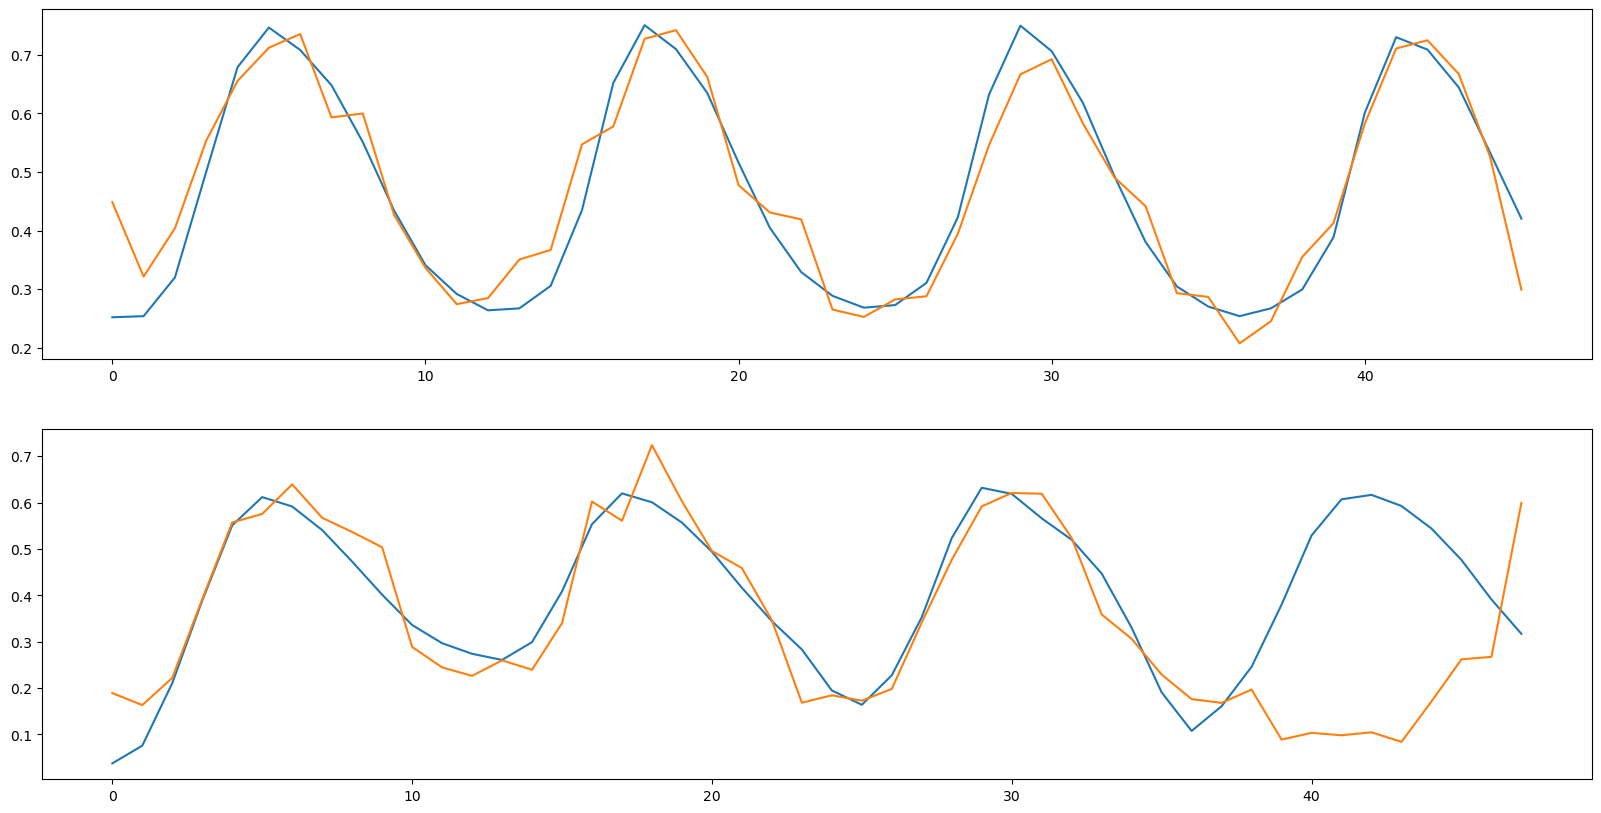

In [508]:
chad_gm = NonlinearLeastSquaresModel()

chad_split =  int(chad_weather.shape[1] * .8)

chad_weather = np.delete(chad_weather, 61, axis=1)
train_features = chad_weather[:, :chad_split]
test_features = chad_weather[:, chad_split:]

print(train_features.shape)
chad_y = np.delete(chad_y, 61, axis=0)
chad_gm.fit(train_features, chad_y[:chad_split])
print(test_features.shape)
chad_prediction = chad_gm.predict(test_features)


uk_split = int(uk_weather.shape[1] * .8)
uk_gm = NonlinearLeastSquaresModel()

uk_weather = np.where(np.isnan(uk_weather), np.nan_to_num(uk_weather, nan=np.nanmin(uk_weather)), uk_weather)

train_features = uk_weather[:, :uk_split]
test_features = uk_weather[:, uk_split:]

uk_gm.fit(train_features, uk_y[:uk_split])
uk_prediction = uk_gm.predict(test_features)

plt.subplots(2, 1, figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(chad_prediction)), chad_y[chad_split:])
plt.plot(np.arange(len(chad_prediction)), chad_prediction)


plt.subplot(2, 1, 2)
plt.plot(np.arange(len(uk_prediction)), uk_y[uk_split:])
plt.plot(np.arange(len(uk_prediction)), uk_prediction)

plt.show()